# Project 2: Segmentation

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Setting up PyMaxFlow: <span style="color:red;">0.5 hour</span>
* 2. Getting your first successful segmentation: <span style="color:red;">6 hours</span>
* 3. Adjusting parameters (e.g. $\lambda$, $\sigma$) and so forth, to get good results: <span style="color:red;">5 hours</span>
* 4. Completing the write-up: <span style="color:red;">0.5 hour</span>

Note that there are two folders within the project.  We have provided some images for you to use in testing your implementation, in the `provided images` folder along with their ground-truth segmentations to compare your results to.  Along with these, we want you to provide 2-4 additional images that you select on which you show your results.  <i>Please use the `provided_images` in that path and place any others in the `user_data` folder, and load all of the images (or user input point location files) via the approapriate relative path.  We will drop your notebook file and your `user_data` folder into our folder (which will have the `provided_images` already) and then run your notebook.</i>




## Preparation:
So that you can focus on the elements of the cost function ( the link weights), you may use a existing implementation of the actual min-cut algorithm itself.  You set up the graph, but it will take care of finding the minimum cut.

For this assignment we will be using a python library called PyMaxFlow.  This library is a python wrapper around the original C++ implementation of the min-cut code from [Vladimir Kolmogorov](http://pub.ist.ac.at/%7Evnk/software.html) (who has co-authored several papers on this subject).    

Note: For windows users, you will need the Visual C++ compiler in order for PyMaxFlow to work.  If you already have Visual Studio, this shouldn't be a problem but if you just want the compiler without Visual Studio, you can download [Build Tools For Visual Studio 2017](https://visualstudio.microsoft.com/downloads/#build-tools-for-visual-studio-2017). Once you have access to the Visual C++ compiler look at the next paragraph for PyMaxFlow installation.

PyMaxFlow requires Cython, which should come standard in your anaconda environment but the command to install that will also be included.  To install PyMaxFlow enter the following commands replacing "YourEnvironmentName" with the name of your anaconda environment.
~~~
conda activate YourEnvironemntName
conda install cython
pip install pymaxflow
~~~
Once PyMaxFlow is installed, to understand how to use the library, there is a great [tutorial page](http://pmneila.github.io/PyMaxflow/tutorial.html) that shows how to get started with some simple examples.  Do the "first example" and perhaps the "binary image restoration" as well.

In [1]:
import maxflow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import ParameterGrid
from scipy.stats import norm
%matplotlib inline



## Annotations:
Graph cut segmentation is an interactive algorithm requiring the user to provide foreground and background seeds.  Provided is a python file that will open a gui and allow you to annotate the image.  This gui is optional and will require additional packages to be installed into your environment.  To install the packages open a terminal and enter the following commands:
~~~
conda activate YourEnvironmentName
conda install scikit-image pillow
~~~
You can use the gui in the following way:
```python
import guiseg
fore, back = guiseg.get_fore_back(image)
image[fore]  # the foreground seeds
image[back]  # the background seeds
```

For the `guiseg` routine to run, I also found it necssary to install PIL ImageTk (For me, it was `sudo apt install python3-pil.imagetk` but it will be different for Conda).

In [2]:
import guiseg

import cv2
#imageBGR = cv2.imread('provided_images/simplecircle.png');
imageBGR = cv2.imread('provided_images/banana.png');
image = imageBGR[:,:,::-1]; # I reverse the BGR from OpenCV to BGR

# When the GUI pops up, you can pick either the "Foreground" or "Background" buttons to
# select pixels to be respective seeds.  Once you're finished, click "Return"
fore, back = guiseg.get_fore_back(image)
print(image[fore][:5])  # foreground seeds (RGB values for all pixels drawn on, but only showing 5)
print(image[back][:5])  # background seeds (RGB values for all pixels drawn on, but only showing 5)

[]
[]




## Graph Cut:
Your code should read in an image and a set of seed pixels and use graph-cut segmentation to segment the image.

You will need to calculate the costs for the t-links (region terms) and the n-links (boundary terms). See the book, the notes/slides, or published papers in this area for ideas of how to define these.  Remember that the t-link weights to a particular terminal (foreground or background) should be large if that pixel looks a lot like the respective foreground/background seeds. The n-link weights should be large if the two neighboring pixels are similar.

Here is [the original paper on graph-cut segmentation](http://www.csd.uwo.ca/~yuri/Papers/iccv01.pdf), which might help with some ideas, but you should look at the literature to see what other costs functions / link weights others have used.

Once the graph is built, use the min-cut algorithm to partition the graph into nodes connected to the foreground node or to the background node, then use these as the resulting labels for the segmentation. Display this result graphically in some fashion overlaid on the input image.  It is best to start with simple images whose foreground and background colors are pretty different and for ones where the edges are pretty clear.  Graph-cut segmentation struggles sometimes with long, thin structures, so you should avoid these types of images early on.



In [3]:
def boundary_term(img, sigma):
    
    right = img[:, 1:, :]
    down = img[:-1,:, :]
    left = img[:, :-1, :]
    up = img[1:,:, :]
    
#     right_diff = np.exp(np.linalg.norm(img[:,:-1, :] - right, axis=2)**2/(2*(sigma**2)))
#     left_diff = np.exp(-np.linalg.norm(img[:,1:, :] - left, axis=2)**2/(2*(sigma**2)))
#     up_diff = np.exp(-np.linalg.norm(img[:-1,:, :] - up, axis=2)**2/(2*(sigma**2)))
#     down_diff = np.exp(-np.linalg.norm(img[1:,:, :] - down, axis=2)**2/(2*(sigma**2)))

    right_diff = norm.pdf(np.linalg.norm(img[:,:-1, :] - right, axis=2), scale=sigma)
    left_diff = norm.pdf(np.linalg.norm(img[:,1:, :] - left, axis=2), scale=sigma)
    up_diff = norm.pdf(np.linalg.norm(img[:-1,:, :] - up, axis=2), scale=sigma)
    down_diff = norm.pdf(np.linalg.norm(img[1:,:, :] - down, axis=2), scale=sigma)
    
    img_x, img_y, _= img.shape

    g = maxflow.Graph[int]()
    
    nodeids = g.add_grid_nodes((img_x-1, img_y-1))
    right_structure = np.array([[0, 0, 0],
                      [0, 0, 1],
                      [0, 0, 0]])
    g.add_grid_edges(nodeids, weights=right_diff[:-1,:], structure=right_structure,
        symmetric=False)
    
    #nodeids = g.add_grid_nodes((img_x-1, img_y-1))
    left_structure = np.array([[0, 0, 0],
                      [1, 0, 0],
                      [0, 0, 0]])
    g.add_grid_edges(nodeids, weights=left_diff[:-1,:], structure=left_structure,
        symmetric=False)
    
    #nodeids = g.add_grid_nodes((img_x-1, img_y-1))
    up_structure = np.array([[0, 1, 0],
                      [0, 0, 0],
                      [0, 0, 0]])
    g.add_grid_edges(nodeids, weights=up_diff[:, :-1], structure=up_structure,
        symmetric=False)
    
    #nodeids = g.add_grid_nodes((img_x-1, img_y-1))
    down_structure = np.array([[0, 0, 0],
                      [0, 0, 0],
                      [0, 1, 0]])
    g.add_grid_edges(nodeids, weights=down_diff[:, :-1], structure=down_structure,
        symmetric=False)
    
    return g, nodeids

In [4]:
def get_fore_back(img, seed_fore, seed_back, bandwidth_fore,bandwidth_back, lam):
    img_x, img_y, _ = img.shape
    img2 = img.reshape(img_x*img_y, 3)
    
    kde_fore = KernelDensity(kernel='gaussian', bandwidth=bandwidth_fore).fit(seed_fore)
    img_fore = kde_fore.score_samples(img2)
    final_fore = np.reshape(img_fore, (img_x, img_y))
    
    kde_back = KernelDensity(kernel='gaussian', bandwidth=bandwidth_back).fit(seed_back)
    img_back = kde_back.score_samples(img2) 
    final_back = np.reshape(img_back, (img_x, img_y)) * 1/ lam
    
    return final_fore, final_back

In [5]:
def graph_cut(img, sigma, bandwidth_fore,bandwidth_back, lam, fore, back):
    
    # fore, back = guiseg.get_fore_back(img)

    bounds = boundary_term(img, sigma)
    g = bounds[0]
    fore2, back2 = get_fore_back(img, img[fore], img[back],bandwidth_fore, bandwidth_back, lam)
    g.add_grid_tedges(bounds[1], fore2[:-1,:-1], back2[:-1,:-1])
    g.maxflow()
    sgm = g.get_grid_segments(bounds[1])
    
    return np.int_(np.logical_not(sgm))

In [6]:
def banana():
    banana = cv2.imread('provided_images/banana.png')
    banana = banana[:,:,::-1]
    fore_b, back_b = guiseg.get_fore_back(banana)
    
    banana_out = graph_cut(banana,.5, 1,1, 1, fore_b, back_b)
    
    return banana_out, fore_b, back_b, banana

In [7]:
output_b, fore_b, back_b, orig_b = banana()

In [8]:
def llama():

    llama = cv2.imread('provided_images/llama.jpg')
    llama = llama[:,:,::-1]
    fore_l, back_l = guiseg.get_fore_back(llama)
    
    img_l = graph_cut(llama,1, 1, 1, 1, fore_l, back_l)
    
    return img_l, fore_l, back_l, llama

In [9]:
output_l, fore_l, back_l, orig_l = llama()

In [10]:
def penguin():

    penguin = cv2.imread('provided_images/penguin.png')
    penguin = penguin[:,:,::-1]
    fore_p, back_p = guiseg.get_fore_back(penguin)
    
    img_p = graph_cut(penguin,.5, 1, 1, 1.2, fore_p, back_p)
    #plt.imshow(img_p)
    #plt.show()
    
    return img_p, fore_p, back_p, penguin

In [11]:
output_p, fore_p, back_p, orig_p = penguin()

In [12]:
def teddy():
    
    teddy = cv2.imread('provided_images/teddy.png')
    teddy = teddy[:,:,::-1]
    fore_t, back_t = guiseg.get_fore_back(teddy)
    
    img_t = graph_cut(teddy,.5, 1, 1, 1.2, fore_t, back_t)

    
    return img_t, fore_t, back_t, teddy
    

In [13]:
output_t, fore_t, back_t, orig_t = teddy()

In [14]:
def grizz():
    grizzly = cv2.imread('user_data/Grizzly_Bear.jpeg')
    grizzly = grizzly[:,:,::-1]
    fore_g, back_g = guiseg.get_fore_back(grizzly)
    
    img_g = graph_cut(grizzly,.5, 1, 1, 2, fore_g, back_g)

    
    return img_g, fore_g, back_g, grizzly

In [15]:
output_g, fore_g, back_g, orig_g = grizz()

In [16]:
def city():
    city = cv2.imread('user_data/city.jpeg')
    city = city[:,:,::-1]
    city = cv2.resize(city,None,fx=0.3,fy=0.3)
    fore_c, back_c = guiseg.get_fore_back(city)
    
    img_c = graph_cut(city,.5, 1, 1, 2, fore_c, back_c)

    
    return img_c, fore_c, back_c, city

In [17]:
output_c, fore_c, back_c, orig_c = city()

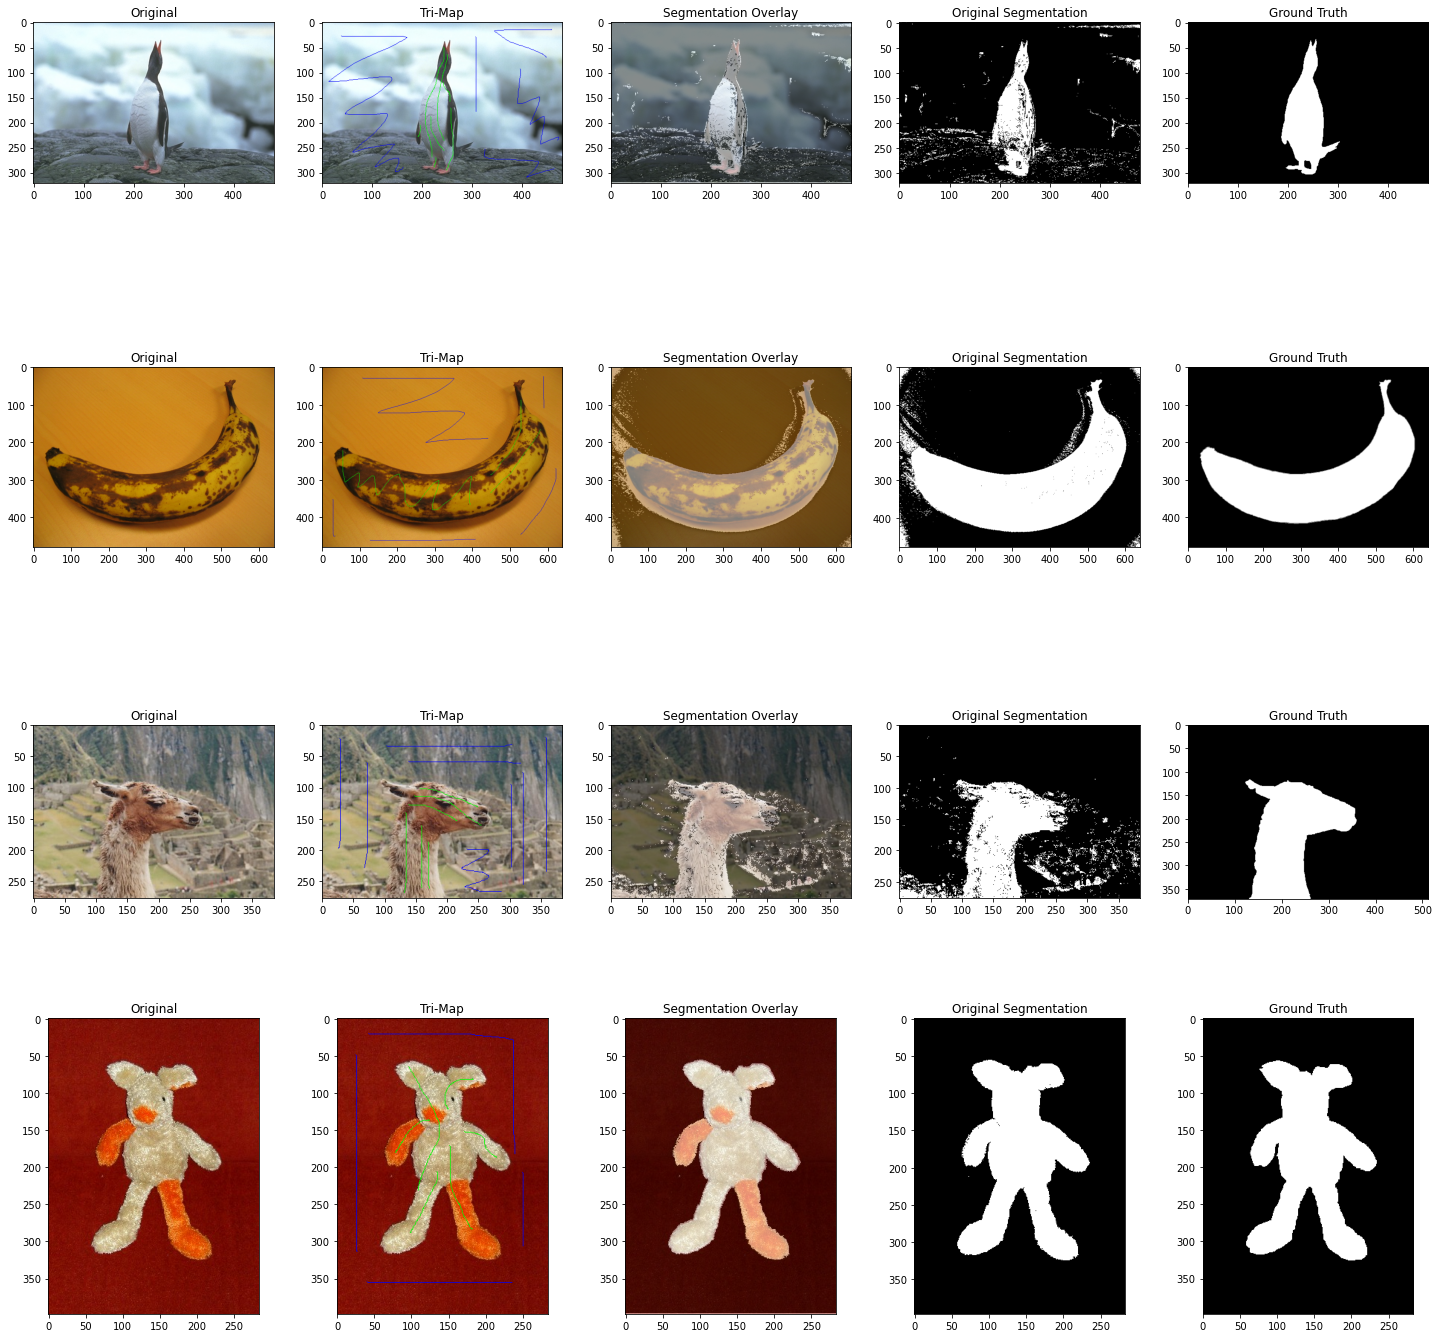

In [18]:
plt.rcParams['figure.figsize'] = [25, 25]
fig, ((ax1, ax2, ax3, ax4, ax5),(ax6,ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15), (ax16,ax17,ax18,ax19,ax20)) = plt.subplots(nrows=4, ncols=5)
# Penguin 
copy_p = orig_p.copy()

copy_p[fore_p] = (0, 250, 0)
copy_p[back_p] = (0, 0, 250)


ax1.imshow(orig_p)

ax2.imshow(copy_p)

ax3.imshow(output_p, cmap='gray')
ax3.imshow(orig_p, alpha=0.55)

ax4.imshow(output_p, cmap='gray')

truth_p = cv2.imread('provided_images/ground_truth/penguin-seg.png')

ax5.imshow(truth_p, cmap='gray')

ax1.title.set_text('Original')
ax2.title.set_text('Tri-Map')
ax3.title.set_text('Segmentation Overlay')
ax4.title.set_text('Original Segmentation')
ax5.title.set_text('Ground Truth')

# Banana

copy_b = orig_b.copy()

copy_b[fore_b] = (0, 250, 0)
copy_b[back_b] = (0, 0, 250)

ax6.imshow(orig_b)

ax7.imshow(copy_b)

ax8.imshow(output_b, cmap='gray')
ax8.imshow(orig_b, alpha=0.55)

ax9.imshow(output_b, cmap='gray')

truth_b = cv2.imread('provided_images/ground_truth/banana-seg.png')

ax10.imshow(truth_b, cmap='gray')

ax6.title.set_text('Original')
ax7.title.set_text('Tri-Map')
ax8.title.set_text('Segmentation Overlay')
ax9.title.set_text('Original Segmentation')
ax10.title.set_text('Ground Truth')


# llama
copy_l = orig_l.copy()

copy_l[fore_l] = (0, 250, 0)
copy_l[back_l] = (0, 0, 250)

ax11.imshow(orig_l)

ax12.imshow(copy_l)

ax13.imshow(output_l, cmap='gray')
ax13.imshow(orig_l, alpha=0.55)

ax14.imshow(output_l, cmap='gray')

truth_l = cv2.imread('provided_images/ground_truth/llama-seg.png')

ax15.imshow(truth_l, cmap='gray')

ax11.title.set_text('Original')
ax12.title.set_text('Tri-Map')
ax13.title.set_text('Segmentation Overlay')
ax14.title.set_text('Original Segmentation')
ax15.title.set_text('Ground Truth')

# teddy

copy_t = orig_t.copy()

copy_t[fore_t] = (0, 250, 0)
copy_t[back_t] = (0, 0, 250)

ax16.imshow(orig_t)

ax17.imshow(copy_t)

ax18.imshow(output_t, cmap='gray')
ax18.imshow(orig_t, alpha=0.55)

ax19.imshow(output_t, cmap='gray')

truth_t = cv2.imread('provided_images/ground_truth/teddy-seg.png')

ax20.imshow(truth_t, cmap='gray')

ax16.title.set_text('Original')
ax17.title.set_text('Tri-Map')
ax18.title.set_text('Segmentation Overlay')
ax19.title.set_text('Original Segmentation')
ax20.title.set_text('Ground Truth')

plt.show()

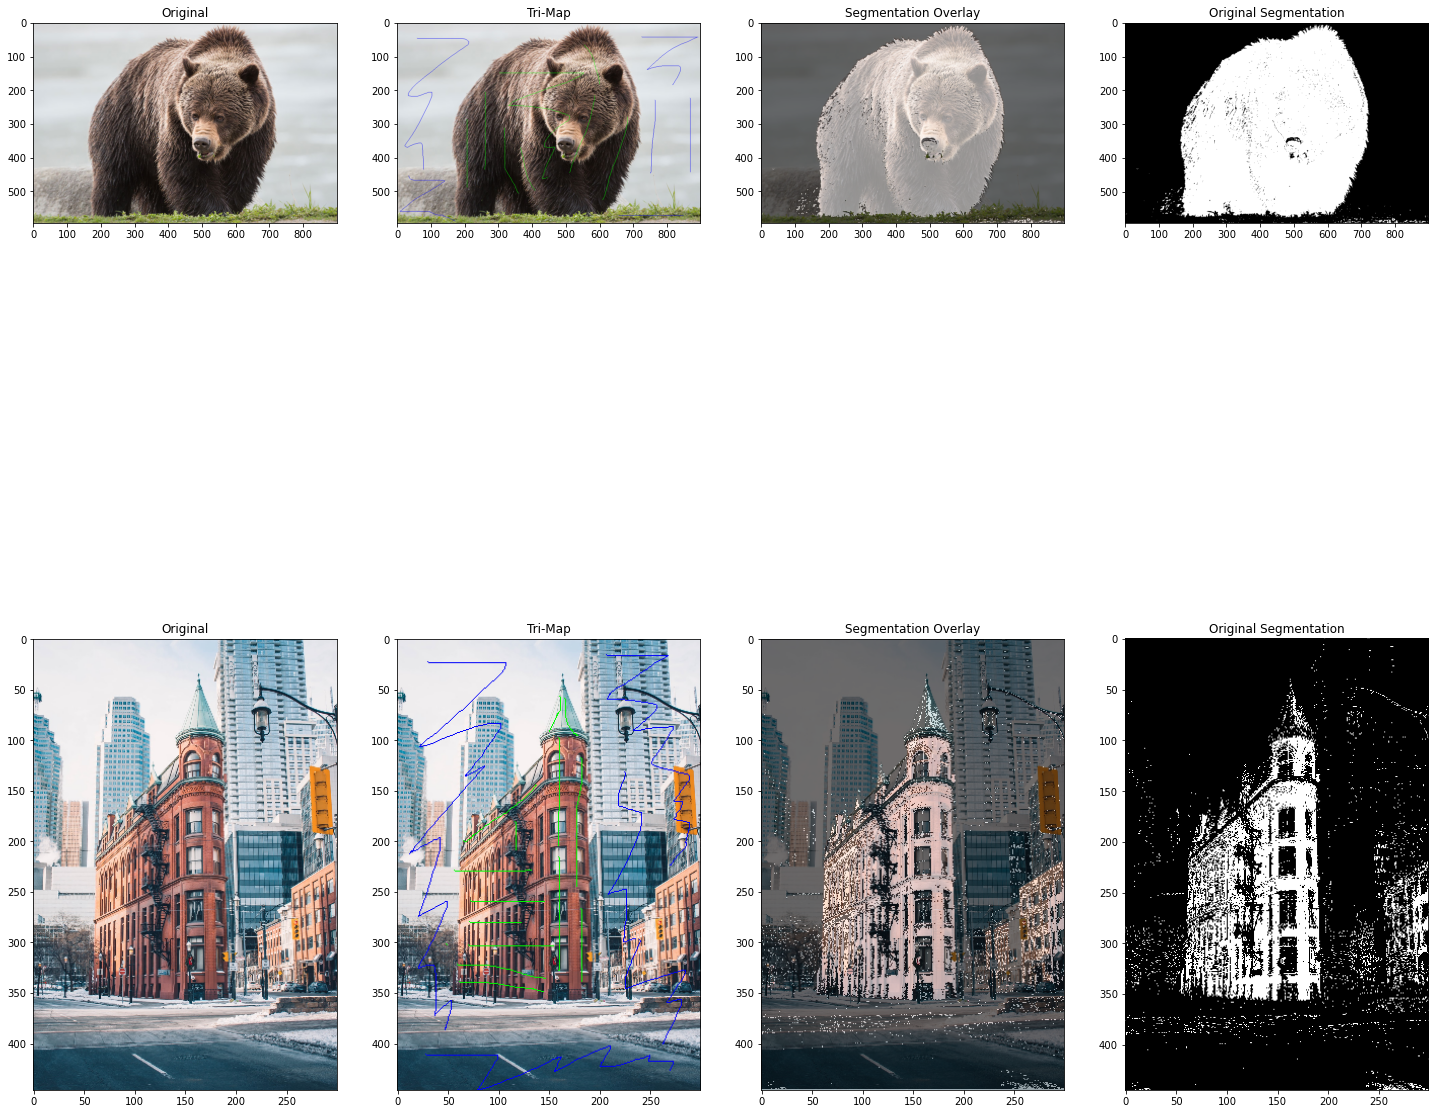

In [19]:
# My own chosen images

fig2, ((ax11, ax22, ax33, ax44), (ax66,ax77,ax88,ax99)) = plt.subplots(nrows=2, ncols=4)

copy_g = orig_g.copy()

copy_g[fore_g] = (0, 250, 0)
copy_g[back_g] = (0, 0, 250)

ax11.imshow(orig_g)

ax22.imshow(copy_g)

ax33.imshow(output_g, cmap='gray')
ax33.imshow(orig_g, alpha=0.45)

ax44.imshow(output_g, cmap='gray')

ax11.title.set_text('Original')
ax22.title.set_text('Tri-Map')
ax33.title.set_text('Segmentation Overlay')
ax44.title.set_text('Original Segmentation')


# City image
copy_c = orig_c.copy()

copy_c[fore_c] = (0, 250, 0)
copy_c[back_c] = (0, 0, 250)

ax66.imshow(orig_c)

ax77.imshow(copy_c)

ax88.imshow(output_c, cmap='gray')
ax88.imshow(orig_c, alpha=0.45)

ax99.imshow(output_c, cmap='gray')

ax66.title.set_text('Original')
ax77.title.set_text('Tri-Map')
ax88.title.set_text('Segmentation Overlay')
ax99.title.set_text('Original Segmentation')




## Grading / Rubric
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly generates the graph network structure (nodes, n-links, t-links).
* [10 pts] Code that produces the boundary term $B(p,q)$ used for n-links.
* [10 pts] Code that produces the region term of the cost $R(p,A)$ used for the t-links.  Remember that you have t-links per pixel, one with cost determined by matching $p$ with the foreground appearance distribution, the other determined relative to the background distribution.  You may use the [sk-learn implementation](https://scikit-learn.org/stable/modules/density.html#kernel-density-estimation) of Kernel Density Estimation.  However you will receive 10 extra points if you implement it yourself.
* [20 pts] Implementing the graph-cut with `pymaxflow` and finding the optimal solution for the input graph.
* [10 pts] Displaying Results in the following format (for each input image you'll show the following 3-4 result images):
   1. Original Image.
   2. Tri-map of what was selected by the user (white for foreground, black for background, gray for unknown).  This can be overlaid on top of a faint copy of the image for context if desired.
   3. Final segmentation.  Again you can overlay it on a faint copy of the original for context.
   4. On the <i>provided images</i> please show a comparison of your resulting segmentaiton with the ground truth.
* [20 pts] Good (certainly not perfect, some of them are challenging, but decent/reasonable) results on the 4 provided images (banana, llama, penguin, teddy).  Each image will receive up to 5 points.
* [10 pts] Demonstrating your algorithm on 2-4 additional images.  At least one of the images should be somewhat easy, one should be somewhat challenging -- expalin why you think they're respectively easy/challenging.


## Write-up:
Provide an explanation for the following items:
* Describe how you determinied/computed the n-link and t-link weights.
* What kinds of image does graph cut segmentation work well for? What kinds of images do you find it struggles with?
* What did you learn from the project?
* What if any suggestions do you have for improving it (for future students)?

**Response:**

I spent a bit of time studying the theory and appliction of the pymaxflow software. Once I felt comfortable with using it I brainstormed how I would apply the weights for each n-link. It took me quit a while to get a working system going, but I essentially subtracted the main image pixel values from a matrix that was all the same value shifted once in each of the four directions. I am not sure that I did the n-link step correctly since changing my sigma did not really have an effect on the segmentation. I also keept finding a lot of noisee in my images that I wa unable to clear out. You can see those struggles most apparently in the Penguin, Llama, and city images. 

After setting up the nodes and computing the n-links, I used SK-Learns KDE to compute t-link weights based on the outputs of the KDE for the foreground and background. I had to adjust the bandwidth and lambda parameters significantly to get improve results. 

It seems that graph cut works with clear foreground/background images. You can see that with th banana and bear image above. It seems to struggle when the colors of the foreground and background are similar for ones like the city. 

I learned about some basic graph theory insights with the node configurations on segmenting the images. I also learned a lot about manipulating image matrices in Numpy. Lastly, I learned how to create better visualizations for my outputs. 